<a href="https://colab.research.google.com/github/mdrk300902/demo-repo/blob/main/DistilBERT_based_Emotion_Classification_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion Classification using DistilBERT: A Deep Learning Approach to Understanding Text Emotions

This project aims to develop a robust natural language processing (NLP) model that can accurately classify emotions expressed in text data. Using the `dair-ai/emotion` dataset, which contains multiple classes of human emotions, we fine-tune a pre-trained DistilBERT transformer model for this multi-class classification task.

## Problem Statement

Identifying emotions in text is a challenging yet essential task for applications ranging from social media monitoring to customer feedback analysis and mental health assessment. The goal is to build a model that can automatically detect and classify emotions such as joy, anger, sadness, fear, surprise, and love from short text snippets.

## Approach

- Utilize the DistilBERT transformer for efficient and powerful language representation.
- Preprocess and tokenize textual data for input compatibility.
- Fine-tune the model with mixed precision and gradient accumulation for performance optimization.
- Implement detailed training and validation monitoring with visualizations of loss, accuracy, and class distribution.
- Evaluate the model using confusion matrices and classification reports to understand performance per emotion category.
- Provide sample predictions to showcase the model’s interpretability and practical utility.

This notebook offers a clear, step-by-step pipeline with integrated visualizations


##**Install Dependencies**

In [ ]:
!pip install -Uqq transformers datasets accelerate torchinfo torchvision
!pip install -Uqq matplotlib seaborn scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.1/888.1 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5

##**Imoports and Configuration**

In [ ]:
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from datasets import load_dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader
from accelerate import Accelerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Configuration Parameters
MODEL_NAME = "distilbert-base-uncased"
MAX_LENGTH = 128
BATCH_SIZE = 16
GRAD_ACCUM_STEPS = 2
NUM_EPOCHS = 10
FREEZE_LAYERS = 2
LEARNING_RATE = 1e-5
SAVE_PATH = "/content/drive/MyDrive/emotion_classifier"
os.makedirs(SAVE_PATH, exist_ok=True)


## **Load Dataset & Visualize Label Distribution**

In [ ]:
dataset = load_dataset('dair-ai/emotion')
label_names = dataset['train'].features['label'].names
labels = dataset['train']['label']
label_counts = pd.Series(labels).value_counts().sort_index()

/tmp/ipython-input-2367032396.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_names, y=label_counts.values, palette='viridis')


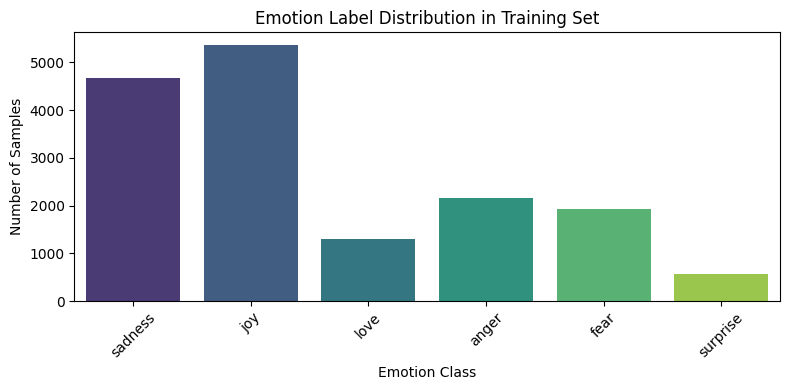

In [ ]:

plt.figure(figsize=(8, 4))
sns.barplot(x=label_names, y=label_counts.values, palette='viridis')
plt.title("Emotion Label Distribution in Training Set")
plt.xlabel("Emotion Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##**Tokenization and DataLoader Setup**

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

def tokenize_fn(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=MAX_LENGTH)

dataset = dataset.map(tokenize_fn, batched=True)
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

train_loader = DataLoader(dataset['train'], batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset['validation'], batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset['test'], batch_size=BATCH_SIZE)

##**Model Initialization and Freezing Layers**

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(label_names))

for layer in model.distilbert.transformer.layer[:FREEZE_LAYERS]:
    for param in layer.parameters():
        param.requires_grad = False

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Display freeze status
for i, layer in enumerate(model.distilbert.transformer.layer):
    status = "Trainable" if any(p.requires_grad for p in layer.parameters()) else "Frozen"
    print(f"Layer {i+1}: {status}")

Layer 1: Frozen
Layer 2: Frozen
Layer 3: Trainable
Layer 4: Trainable
Layer 5: Trainable
Layer 6: Trainable


##**Training Setup**

In [ ]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup


accelerator = Accelerator(mixed_precision='fp16', gradient_accumulation_steps=GRAD_ACCUM_STEPS)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
total_steps = (len(train_loader) // GRAD_ACCUM_STEPS) * NUM_EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1*total_steps), num_training_steps=total_steps)

model, optimizer, train_loader, val_loader = accelerator.prepare(model, optimizer, train_loader, val_loader)

##**Training Loop with Metrics Collection**

In [ ]:
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc="Training", leave=False)

    for step, batch in enumerate(progress_bar):
        inputs = {k: v.to(accelerator.device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
        labels = batch['label'].to(accelerator.device)
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        accelerator.backward(loss)

        if (step + 1) % GRAD_ACCUM_STEPS == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        progress_bar.set_postfix(loss=loss.item())

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating", leave=False):
            inputs = {k: v.to(accelerator.device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
            labels = batch['label'].to(accelerator.device)
            outputs = model(**inputs, labels=labels)
            val_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            val_correct += (preds == labels).sum().item()

    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / len(dataset['validation'])
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Training loss: {avg_train_loss:.4f} | Validation loss: {avg_val_loss:.4f} | Validation accuracy: {val_accuracy:.4f}")

    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    accelerator.save(unwrapped_model.state_dict(), os.path.join(SAVE_PATH, f"distilbert_epoch{epoch+1}.pt"))
    print(f"Checkpoint saved for epoch {epoch+1}")


Epoch 1/10


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Training loss: 1.2674 | Validation loss: 0.5565 | Validation accuracy: 0.8060
Checkpoint saved for epoch 1

Epoch 2/10


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Training loss: 0.3559 | Validation loss: 0.2394 | Validation accuracy: 0.9170
Checkpoint saved for epoch 2

Epoch 3/10


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Training loss: 0.1949 | Validation loss: 0.2100 | Validation accuracy: 0.9205
Checkpoint saved for epoch 3

Epoch 4/10


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Training loss: 0.1501 | Validation loss: 0.1901 | Validation accuracy: 0.9235
Checkpoint saved for epoch 4

Epoch 5/10


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Training loss: 0.1255 | Validation loss: 0.1781 | Validation accuracy: 0.9255
Checkpoint saved for epoch 5

Epoch 6/10


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Training loss: 0.1053 | Validation loss: 0.1767 | Validation accuracy: 0.9280
Checkpoint saved for epoch 6

Epoch 7/10


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Training loss: 0.0962 | Validation loss: 0.1689 | Validation accuracy: 0.9325
Checkpoint saved for epoch 7

Epoch 8/10


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Training loss: 0.0862 | Validation loss: 0.1710 | Validation accuracy: 0.9295
Checkpoint saved for epoch 8

Epoch 9/10


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Training loss: 0.0813 | Validation loss: 0.1738 | Validation accuracy: 0.9320
Checkpoint saved for epoch 9

Epoch 10/10


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Validating:   0%|          | 0/125 [00:00<?, ?it/s]

Training loss: 0.0769 | Validation loss: 0.1707 | Validation accuracy: 0.9325
Checkpoint saved for epoch 10


##**Visualize Training Progerss**

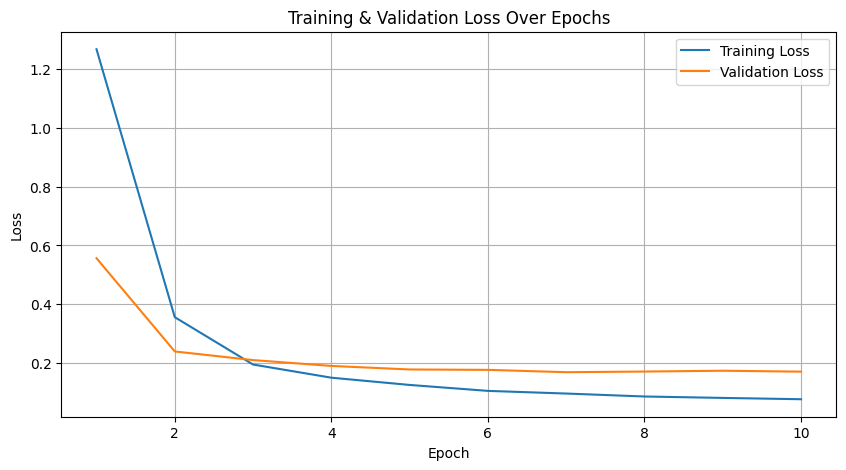

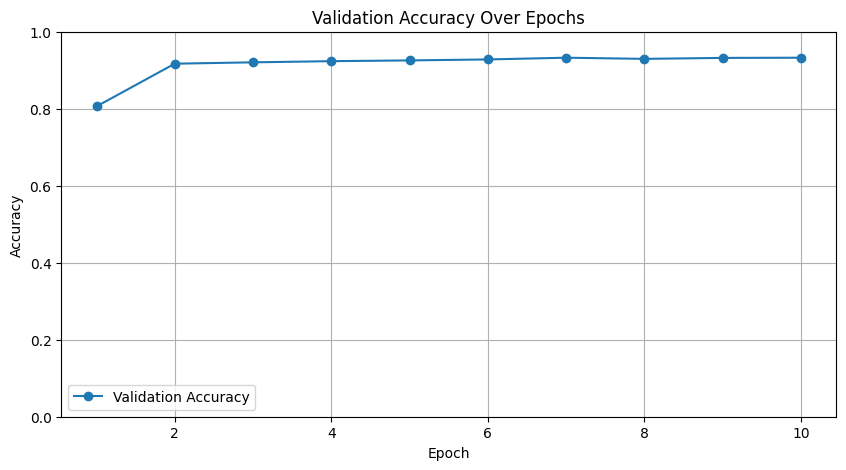

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS+1), train_losses, label='Training Loss')
plt.plot(range(1, NUM_EPOCHS+1), val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS+1), val_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()

##**Final Test Visualization**

In [ ]:
print("\nLoading last epoch model for final evaluation...")
model.load_state_dict(torch.load(os.path.join(SAVE_PATH, f"distilbert_epoch{NUM_EPOCHS}.pt")))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        inputs = {k: v.to(accelerator.device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
        labels = batch['label'].to(accelerator.device)
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

In [ ]:
test_accuracy = sum([yt == yp for yt, yp in zip(y_true, y_pred)]) / len(y_true)
print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")


Final Test Accuracy: 0.9175


##**Confusion Matrix Visualization**

In [ ]:
print("\nLoading last epoch model for final evaluation...")
model.load_state_dict(torch.load(os.path.join(SAVE_PATH, f"distilbert_epoch{NUM_EPOCHS}.pt")))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        inputs = {k: v.to(accelerator.device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
        labels = batch['label'].to(accelerator.device)
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

<Figure size 700x700 with 0 Axes>

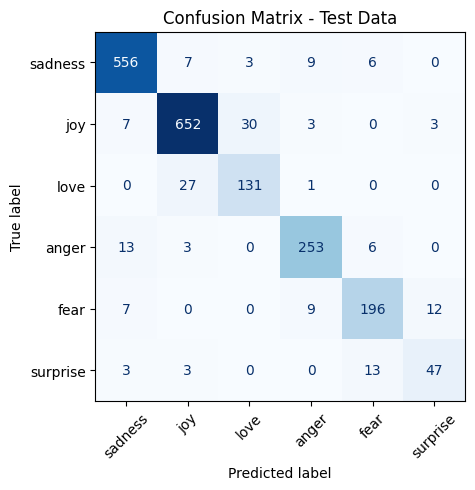

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7, 7))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names).plot(
    cmap='Blues', colorbar=False)
plt.title("Confusion Matrix - Test Data")
plt.xticks(rotation=45)
plt.show()

##**Classification Report**

In [ ]:
print("\nClassification Report (Test Set):")
print(classification_report(y_true, y_pred, target_names=label_names))


Classification Report (Test Set):
              precision    recall  f1-score   support

     sadness       0.95      0.96      0.95       581
         joy       0.94      0.94      0.94       695
        love       0.80      0.82      0.81       159
       anger       0.92      0.92      0.92       275
        fear       0.89      0.88      0.88       224
    surprise       0.76      0.71      0.73        66

    accuracy                           0.92      2000
   macro avg       0.88      0.87      0.87      2000
weighted avg       0.92      0.92      0.92      2000



##**Example Predictions**

In [ ]:
dataset.reset_format()

test_texts = dataset['test']['text'][:10]
test_labels = dataset['test']['label'][:10]

inputs = tokenizer(test_texts, padding='max_length', truncation=True, max_length=MAX_LENGTH, return_tensors="pt").to(accelerator.device)
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()

for i in range(len(test_texts)):
    print(f"\nText: {test_texts[i]}\nTrue Emotion: {label_names[test_labels[i]]}\nPredicted: {label_names[preds[i]]}")

dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


Text: im feeling rather rotten so im not very ambitious right now
True Emotion: sadness
Predicted: sadness

Text: im updating my blog because i feel shitty
True Emotion: sadness
Predicted: sadness

Text: i never make her separate from me because i don t ever want her to feel like i m ashamed with her
True Emotion: sadness
Predicted: sadness

Text: i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived
True Emotion: joy
Predicted: joy

Text: i was feeling a little vain when i did this one
True Emotion: sadness
Predicted: sadness

Text: i cant walk into a shop anywhere where i do not feel uncomfortable
True Emotion: fear
Predicted: fear

Text: i felt anger when at the end of a telephone call
True Emotion: anger
Predicted: anger

Text: i explain why i clung to a relationship with a boy who was in many ways immature and uncommitted despite the excitement i should have been feeling for getting accepted into the masters program at t